# 📚 PyTorch Practice Notebook - Lecture 1 Exercises

**Based on:** SAIR PyTorch Mastery - Lecture 1: From NumPy to Production Neural Networks

**Instructions:** Complete the exercises below to test your understanding of PyTorch fundamentals. Try to solve them without looking at the original notebook first!

## 🔧 Setup & Imports

Run this cell first to set up your environment.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


## 🎯 Exercise 1: Understanding Tensors & Autograd

### Part A: Manual Gradient Verification

**Task:** Create a simple computation graph and compute gradients both manually and with PyTorch's autograd.

Given:
- x = 3.0
- w = 2.0  
- b = 1.0

Compute: y = w*x + b, then loss = y²

**Your job:**
1. Create PyTorch tensors with gradient tracking
2. Compute the forward pass
3. Compute gradients using `.backward()`
4. Verify by manually computing ∂loss/∂w and ∂loss/∂x using chain rule

In [2]:
# =========== YOUR CODE HERE ===========
x = torch.tensor(3.0, requires_grad=True)
w = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

y = w * x + b
loss = y.pow(2)

# Backward pass

loss.backward()

# Print gradients
print(50*"-", "    AUTO GRAD    ", 50*"-")
print(f"x = {x}, dL_dx = {x.grad}")
print(f"w = {w}, dL_dw = {w.grad}")
print(f"b = {b}, dL_db = {b.grad}")


# Manual verification
# Compute manually: ∂loss/∂w = ? and ∂loss/∂x = ?
dL_dy = 2 * y
dL_dx = (w) * (dL_dy)
dL_dw = (x) * (dL_dy)
dL_db = (dL_dy)

print(50*"-", "    MANUAL GRADS    ", 50*"-")
print("dL/dx is equal to x.grad ? --->", torch.allclose(dL_dx, x.grad))
print("dL/dw is equal to w.grad ? --->", torch.allclose(dL_dw, w.grad))
print("dL/db is equal to b.grad ? --->", torch.allclose(dL_db, b.grad))


# =========================================

--------------------------------------------------     AUTO GRAD     --------------------------------------------------
x = 3.0, dL_dx = 28.0
w = 2.0, dL_dw = 42.0
b = 1.0, dL_db = 14.0
--------------------------------------------------     MANUAL GRADS     --------------------------------------------------
dL/dx is equal to x.grad ? ---> True
dL/dw is equal to w.grad ? ---> True
dL/db is equal to b.grad ? ---> True


### Part B: Gradient Accumulation Demonstration

**Task:** Show what happens when you forget `optimizer.zero_grad()`.

1. Create a simple linear model
2. Run two training steps WITHOUT zero_grad
3. Show that gradients accumulate
4. Fix by adding zero_grad

In [3]:
# =========== YOUR CODE HERE ===========

# Helper function to print model gradients:
def print_gradients(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Parameter: {name}: Gradient: {param.grad}")


print(10*"-", "!!! With (NO) Zero Grad !!!", 10*"-")
model = nn.Linear(3, 1)

X = torch.randn(5, 3)
y = torch.randn(5, 1)

optimizer = optim.SGD(model.parameters(), lr = 0.01)

output = model(X)
loss = ((y - output)**2).mean()
loss.backward()
optimizer.step()
print_gradients(model)

# Second forward-backward (no zero_grad)
# Print gradient after second iteration
output_2 = model(X)
loss_2 = ((y - output_2)**2).mean()
loss_2.backward()
optimizer.step()
print_gradients(model)
# Show that gradients doubled!

# Now do it correctly with zero_grad
# =========================================


print(10*"-", "!!! With Zero Grad !!!", 10*"-")
# Create a simple model
model = nn.Linear(3, 1)

# Create dummy data
X = torch.randn(5, 3)
y = torch.randn(5, 1)

# Create optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01)

# First forward-backward (no zero_grad)
output = model(X)
loss = ((y - output)**2).mean()
optimizer.zero_grad()
loss.backward()
optimizer.step()
print_gradients(model)

# Second forward-backward (no zero_grad)
output_2 = model(X)
loss_2 = ((y - output_2)**2).mean()
optimizer.zero_grad()
loss_2.backward()
optimizer.step()
print_gradients(model)

---------- !!! With (NO) Zero Grad !!! ----------
Parameter: weight: Gradient: tensor([[ 0.3354,  2.2668, -0.6727]])
Parameter: bias: Gradient: tensor([1.5845])
Parameter: weight: Gradient: tensor([[ 0.6617,  4.4332, -1.2948]])
Parameter: bias: Gradient: tensor([3.0893])
---------- !!! With Zero Grad !!! ----------
Parameter: weight: Gradient: tensor([[ 0.3130, -0.3809, -0.5220]])
Parameter: bias: Gradient: tensor([0.0334])
Parameter: weight: Gradient: tensor([[ 0.3087, -0.3750, -0.5162]])
Parameter: bias: Gradient: tensor([0.0305])


## 🏗️ Exercise 2: Building Neural Networks with nn.Module

### Part A: Convert NumPy Network to PyTorch

**Task:** Convert this NumPy-style network to PyTorch using `nn.Module`.

Original NumPy network:
```python
class NumPyNetwork:
    def __init__(self):
        self.W1 = np.random.randn(10, 20)
        self.b1 = np.zeros(20)
        self.W2 = np.random.randn(20, 5)
        self.b2 = np.zeros(5)
        
    def forward(self, X):
        z1 = X @ self.W1 + self.b1
        a1 = np.maximum(0, z1)  # ReLU
        z2 = a1 @ self.W2 + self.b2
        return z2
```

Create a PyTorch version with:
1. Proper inheritance from `nn.Module`
2. PyTorch layers instead of manual weights
3. ReLU activation
4. Forward method

In [4]:
# =========== YOUR CODE HERE ===========
class PyTorchNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Define layers here
        self.layer1 = nn.Linear(10, 20)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(20, 5)

    def forward(self, x):
        # Implement forward pass
        x = self.layer1(x)
        x = self.relu(x)
        return self.layer2(x)
# =========================================

### Part B: Test Your Network

Test that your network works correctly:

In [5]:
# Test your network
model = PyTorchNetwork()

# Create dummy input
X_test = torch.randn(8, 10)  # batch_size=8, features=10

# Forward pass
output = model(X_test)

print(f"Input shape: {X_test.shape}")
print(f"Output shape: {output.shape}")
print(f"Output range: [{output.min():.3f}, {output.max():.3f}]")

Input shape: torch.Size([8, 10])
Output shape: torch.Size([8, 5])
Output range: [-0.520, 0.463]


## 🔄 Exercise 3: Complete Training Loop

### Part A: Fix the Buggy Training Loop

**Task:** This training loop has several bugs. Identify and fix them all.

Epoch 10: Loss = 1.0771
Epoch 20: Loss = 0.9517
Epoch 30: Loss = 0.8560
Epoch 40: Loss = 0.8107
Epoch 50: Loss = 0.7265


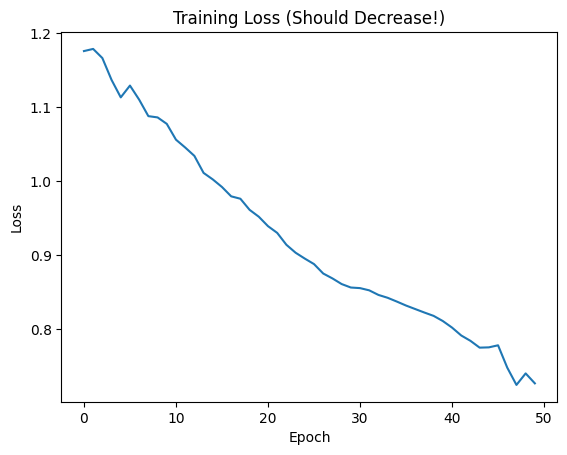

In [6]:
# =========== BUGGY CODE - FIX ME! ===========
class BuggyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(5, 10)
        # Adding an activation function here
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(10, 1)

    def forward(self, x):
        # x = torch.relu(self.layer1(x))
        x = self.layer1(x)
        x = self.relu(x)
        return self.layer2(x)

# Create model and optimizer
model = BuggyNet()
# !!!!! I CHANGED THE LEARNING RATE, THE RESULT IS QUITELY ACCEPTABLE
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Dummy data
X = torch.randn(100, 5)
y = torch.randn(100, 1)

# Training loop with bugs
losses = []
for epoch in range(50):
    # Forward pass
    predictions = model(X)
    loss = ((predictions - y) ** 2).mean()
    losses.append(loss.item())

    # Backward pass
    # ZERO GRAD THE OPTMIZER !!!!!!!!!!!!!!!!!!
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# Plot results
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Should Decrease!)')
plt.show()
# ============================================

### Part B: Write a Correct Training Loop

**Task:** Write a complete, correct training loop from scratch for a regression problem.

Requirements:
1. Create a neural network with 2 hidden layers
2. Use proper loss function for regression
3. Include all 6 training steps
4. Track and plot loss
5. Make it device-agnostic

Epoch: 10, Loss: 0.9661
Epoch: 20, Loss: 0.9347
Epoch: 30, Loss: 0.9200
Epoch: 40, Loss: 0.9107
Epoch: 50, Loss: 0.9035
Epoch: 60, Loss: 0.8977
Epoch: 70, Loss: 0.8928
Epoch: 80, Loss: 0.8885
Epoch: 90, Loss: 0.8848
Epoch: 100, Loss: 0.8814


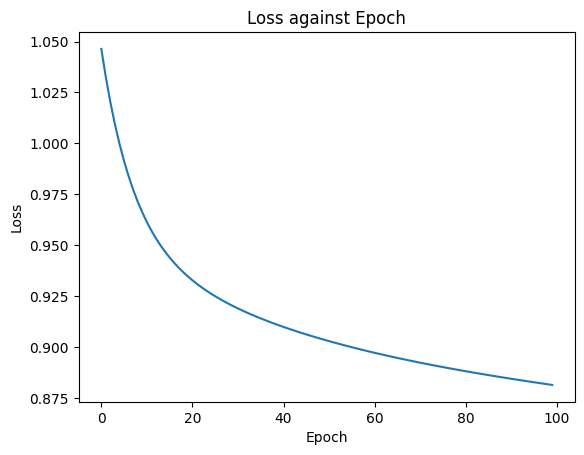

In [7]:
# =========== YOUR CODE HERE ===========
# 1. Define your network architecture
class PracticeNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

# 2. Set device (CPU or GPU)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Create dummy data

X = torch.randn(200, 7).to(device)
y = torch.randn(200, 1).to(device)

# 4. Initialize model, loss function, optimizer

model = PracticeNet(input_dim = X.shape[1]).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 5. Training loop (100 epochs)

losses = []
for epoch in range(100):
    # 1. all componenet already moved to the available device
    model.train()
    # ======== FORWARD PASS ==============
    # 2. get the output
    output = model(X)
    # 3. computer the loss
    loss = loss_fn(output, y)
    # 4.zero grad the optimizer (clear the cache of the previous weights)
    optimizer.zero_grad()
    # ======= BACKWARD PASS ==============
    # 5. backward the loss, 6. update the parameters, 7. finally append the loss for tracking
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")


# 6. Plot loss curve
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss against Epoch")
plt.show()

# =========================================

## 💾 Exercise 4: Model Persistence

### Part A: Save and Load Model Weights

**Task:** Train a simple model, save it, load it into a new model, and verify they produce identical predictions.

In [8]:
# =========== YOUR CODE HERE ===========
# 1. Create and train a simple model

model = PracticeNet(4).to(device)
X = torch.randn(100, 4).to(device)
y = torch.randn(100, 1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 2. Train for a few epochs
for epoch in range(10):
    model.train()

    output = model(X)
    loss = loss_fn(output, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print("TRAINING FINISHED")

# 3. Save model weights
torch.save(model.state_dict(), "saving_test.pth")

# 4. Create a NEW model with same architecture
# new_model = ...
new_model = PracticeNet(4).to(device)

# 5. Load saved weights into new model
state = torch.load("saving_test.pth")
new_model.load_state_dict(state)

# 6. Verify predictions match
test_input = torch.randn(5, 4).to(device)
original_pred = model(test_input)
loaded_pred = new_model(test_input)
print(f"Predictions match: {torch.allclose(original_pred, loaded_pred, rtol=1e-4)}")

# =========================================

TRAINING FINISHED
Predictions match: True


### Part B: Create Training Checkpoints

**Task:** Save a checkpoint that allows resuming training. Include:
- Model state_dict
- Optimizer state_dict
- Epoch number
- Loss value

Then demonstrate loading and resuming training.

Epoch: 10, Loss: 1.1795
Epoch: 20, Loss: 1.1409
Epoch: 30, Loss: 1.1248
Saving Checkpoint....
Resume training....
Epoch: 30, Loss: 1.1236
Epoch: 40, Loss: 1.1136
Epoch: 50, Loss: 1.1056
Epoch: 60, Loss: 1.0987


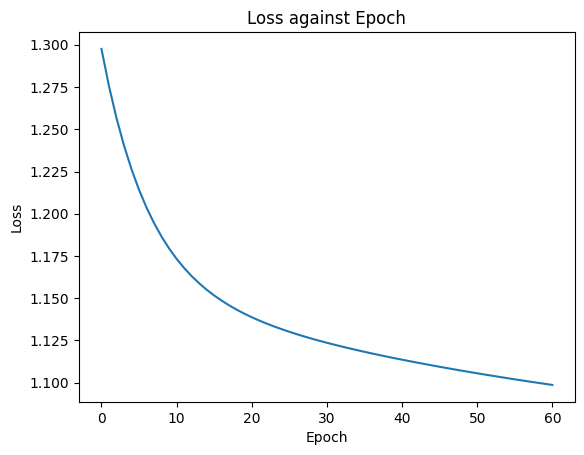

In [9]:
# =========== YOUR CODE HERE ===========
# 1. Train a model for 30 epochs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X = torch.randn(200, 7).to(device)
y = torch.randn(200, 1).to(device)

model = PracticeNet(input_dim = X.shape[1]).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

losses = []
for epoch in range(30):
    model.train()

    # ======== FORWARD PASS ==============
    output = model(X)

    loss = loss_fn(output, y)

    optimizer.zero_grad()
    # ======= BACKWARD PASS ==============

    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

# 2. Create checkpoint dictionary

checkpoint = {
    'epoch': epoch, # using the final epoch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss    # using the last loss
}

# 3. Save checkpoint
print("Saving Checkpoint....")
torch.save(checkpoint, 'checkpoint.pth')

# 4. Create new model and optimizer


model = PracticeNet(input_dim = X.shape[1]).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 5. Load checkpoint

resume = torch.load('checkpoint.pth')
model.load_state_dict(resume['model_state_dict'])
optimizer.load_state_dict(resume['optimizer_state_dict'])

# 6. Resume training from epoch 30

print("Resume training....")
for epoch in range(resume['epoch'], 60):
    model.train()

    # ======== FORWARD PASS ==============
    output = model(X)

    loss = loss_fn(output, y)

    optimizer.zero_grad()
    # ======= BACKWARD PASS ==============

    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")


plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss against Epoch")
plt.show()

# =========================================

## 🚀 Exercise 5: Real-World Application

### Part A: Boston Housing Prediction

**Task:** Use PyTorch to predict Boston housing prices.

Steps:
1. Load Boston housing dataset
2. Split into train/test
3. Standardize features
4. Create PyTorch model
5. Train model
6. Evaluate on test set

In [10]:
def load_boston_from_kaggle():
    import kagglehub
    import pandas as pd
    from pathlib import Path

    # Download latest version
    path = Path(kagglehub.dataset_download("schirmerchad/bostonhoustingmlnd")) / "housing.csv"
    df = pd.read_csv(path)
    return df.iloc[:, :-1].values, df.iloc[:, [-1]].values


Couldn't load boston dataset from sklearn, trying kaggle...
Using Colab cache for faster access to the 'bostonhoustingmlnd' dataset.
Using device: cuda
Epoch: 100, Loss: 233075736576.0000
Epoch: 200, Loss: 199899381760.0000
Epoch: 300, Loss: 149901967360.0000
Epoch: 400, Loss: 99178831872.0000
Epoch: 500, Loss: 60297527296.0000
Epoch: 600, Loss: 36959453184.0000
Epoch: 700, Loss: 24776820736.0000
Epoch: 800, Loss: 18225580032.0000
Epoch: 900, Loss: 14415924224.0000
Epoch: 1000, Loss: 12058723328.0000
Test Loss: 10746931200.0000


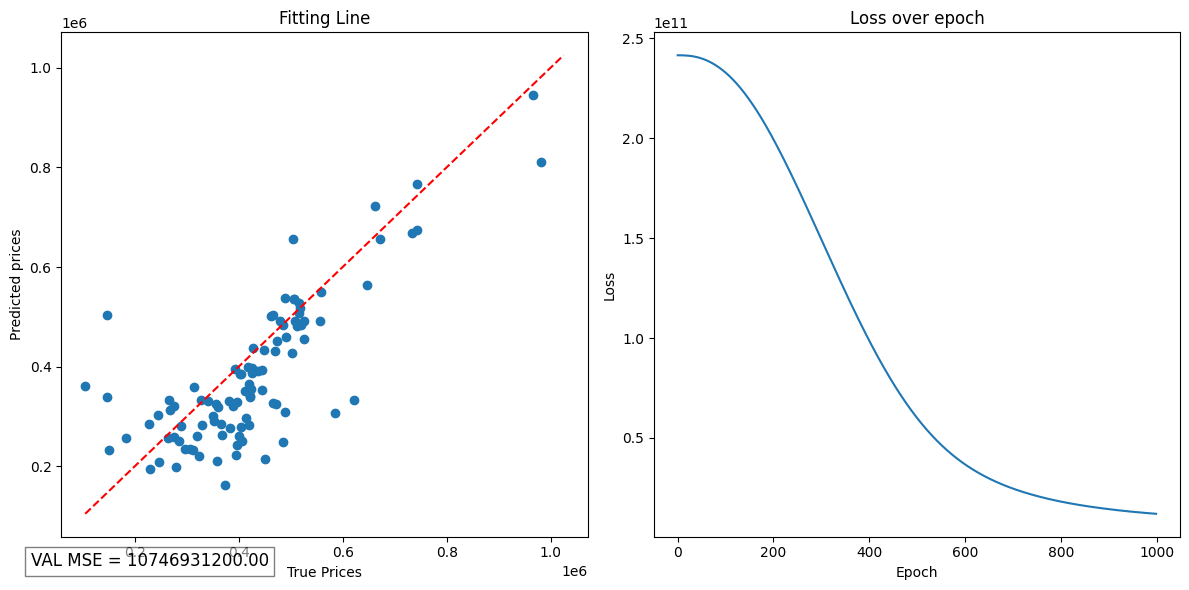

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# =========== YOUR CODE HERE ===========
# 1. Load dataset
try:
    from sklearn.datasets import load_boston
    X, y = load_boston(return_X_y=True)
except Exception as e:
    print(f"Couldn't load boston dataset from sklearn, trying kaggle...")
    X, y = load_boston_from_kaggle()

# 2. Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 3. Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#initializing the device
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 4. Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# 5. Define model architecture

class BostonPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, X):
        return self.net(X)

# 6. Create model instance

model = BostonPredictor(input_size = X_train.shape[1]).to(device)

# 7. Training loop
# ...

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

losses = []
model.train()
for epoch in range(1000):

    # ======== FORWARD PASS ==============
    indices = torch.randperm(X_train_tensor.shape[0])
    output = model(X_train_tensor[indices])

    loss = loss_fn(output, y_train_tensor[indices])

    # ======= BACKWARD PASS ==============
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss:.4f}")



# 8. Evaluate on test set

model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = nn.MSELoss()(test_predictions, y_test_tensor)
    print(f"Test Loss: {test_loss.item():.4f}")

# 9. Plot predictions vs actual

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(y_test_tensor.cpu().numpy(), test_predictions.cpu().numpy())
ax[0].plot([y.min(), y.max()], [y.min(), y.max()], "r--")
# plot the model score
ax[0].text(1, 17, f'VAL MSE = {test_loss:.2f}', fontsize=12, color='black',
         bbox=dict(facecolor='white', alpha=0.5))
ax[0].set_xlabel('True Prices')
ax[0].set_ylabel('Predicted prices')
ax[0].set_title('Fitting Line')

ax[1].plot(losses)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss over epoch')
plt.tight_layout()
plt.show()

# =========================================

## 🧪 Challenge Problems

### Challenge 1: Debug a Non-Training Model

Create a model that SHOULD learn but doesn't (loss stays constant). Include at least 3 common bugs. Then write debugging code to identify each bug.

In [12]:
# =========== CHALLENGE 1 ===========
# Create a buggy model
class BuggyModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Add bugs here
        self.layer1 = nn.Linear(5, 8)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(16, 1) #shape mismatch
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        return self.layer2(x)

# Debugging function
def debug_model(model, X, y):
    """Identify why model isn't training"""
    print("Debugging Model...")
    # 0. Check if the model forward is correct
    try:
        output = model(X)
    except Exception as e:
        print(f"There is a shape mismatching, please recheck the input and model initialization !: {e}")

    # Check 1: Are gradients being computed?
    for name, param in model.named_parameters():
        if param.grad is None:
            print(f"⚠️ No gradient for {name}")
    # Check 2: Are parameters updating?
    for name, param in model.named_parameters():
        if not param.requires_grad:
            print(f"⚠️ Cannot update parameter: {name}")
    # Check 3: Is loss changing?

    # Check 4: Are weights reasonable?

    # Check 5: Is learning rate appropriate?

    print("Debugging complete!")

# Create and debug model
model = BuggyModel()
X = torch.randn(10,5)
y = torch.randn(10,1)
debug_model(model, X, y)
# ===================================

Debugging Model...
There is a shape mismatching, please recheck the input and model initialization !: mat1 and mat2 shapes cannot be multiplied (10x8 and 16x1)
⚠️ No gradient for layer1.weight
⚠️ No gradient for layer1.bias
⚠️ No gradient for layer2.weight
⚠️ No gradient for layer2.bias
Debugging complete!


### Challenge 2: Create a Learning Rate Finder

Implement a learning rate finder that:
1. Trains the model with exponentially increasing learning rates
2. Plots loss vs learning rate
3. Identifies optimal learning rate range

In [13]:
# =========== CHALLENGE 2 ===========
def find_learning_rate(model, X, y, min_lr=1e-5, max_lr=1, steps=100):
    """Find optimal learning rate range"""

    # Your implementation here

    # Return best learning rate
    return best_lr

# Usage:
# model = YourModel()
# optimal_lr = find_learning_rate(model, X_train, y_train)
# print(f"Optimal learning rate: {optimal_lr}")
# ===================================

## 📊 Assessment Questions

Answer these questions in markdown cells:

### Q1: What's the difference between these two lines?
```python
x = torch.tensor([1.0, 2.0, 3.0])
x = torch.Tensor([1.0, 2.0, 3.0])
```
### Answer1:
`Tensor` is the alias for `FloatTensot`, and hence it infer a float32 datatype .
while `tensor` yields the default datatype of the input, its recommended when creating tensor from existing data.

---

### Q2: When should you use `model.train()` vs `model.eval()`?
### Answer 2:
we use `model.train()` when we want to train the model, this tells pytorch to keep track of the models parameters gradients, and we use
`model.eval()` when we want to make inference from the model, here we dont need to keep track of the gradients because we don't need to update the parameters.

---
### Q3: Why do we need both `loss.backward()` and `optimizer.step()`? Can't one function do both?
### Answer 3:
`loss.backward()` tells pytorch autograd engine to use inverse triverse to calculate the gradients, `optimizer.step()` is used to update the model parameters, they have different functionality.

---
### Q4: What happens if you forget to call `optimizer.zero_grad()` in a training loop?
### Answer 4:
`optimizer.zero_grad()` tells the optimizer to clear the old cache of the gradients, this means if we forger to call it, the gradients will accummulate yielding un-predictable behaviour and wrong representation of the parameters.

---
### Q5: How do you move a model to GPU? What common error occurs if you forget something?
### Answer 5:
using `torch.device` to select a device, and `model.to(device)` to move the model to the specific device, there's a common error where we move the model and forgot to move the data into the device.

---
### Q6: What's the difference between saving `model.state_dict()` and saving the entire model with `torch.save(model, ...)`?
### Answer 6:
`torch.save(model)` dumps the entire architecture with the weights, this is not recommended and not efficient, while `model.state_dict()` dictionary containing weights with their values, this is the efficient way to save model, because it only stores what really matter.

---
### Q7: Why is it important to use `with torch.no_grad():` during inference?
### Answer 7:
`torch.no_grad()` stops gradient tracking, **we don't need gradients during inference**, this speed ups calculations and free ups memory.

# Book Exercise:

### 3. Why is it generally preferable to use a logistic regression classifier rather than a classic perceptron (i.e., a single layer of threshold logic units trained using the perceptron training algorithm)? How can you tweak a perceptron to make it equivalent to a logistic regression classifier?

    1. Perceptron uses TLU's to predict the class, and hence it provides no class probabilities.
    2. We can use no regularization, and the training only stops when we have no error's in the training datasets, and hence, perceptron is susceptible to overfitting.

### 4. Why was the sigmoid activation function a key ingredient in training the first MLPs?

    Sigmoid activation function has a well defined non-zero derivative every where, unlike the step function, which make gradient descent works.

### 5. Name three popular activation functions.

   1. The Sigmoid.
   2. The Hyperbolic Tangent (tanh).
   3. The Rectified Linear Unit (ReLU).

### 6. Suppose you have an MLP composed of one input layer with 10 passthrough neurons, followed by one hidden layer with 50 artificial neurons, and finally one output layer with 3 artificial neurons. All artificial neurons use the ReLU activation function.

A. What is the shape of the input matrix X?
* the shape is number of examples by 10 (m, 10)


B. What are the shapes of the hidden layers weight matrix W and bias vector b ?
   * W has the shape: (10, 50)
   * B has the shape: (1, 50)


C. What are the shapes of the output layers weight matrix W and bias vector b ?
* W has the shape: (50, 3)
* B has the shape: (1, 3)


D. What is the shape of the network’s output matrix Y?
* Output matrix has the shape (m, 3) where m is the number of examples of the input matrix X.


   E. Write the equation that computes the network’s output matrix Y as a function of X, W , b , W , and b .

   1. a1 = Relu1(W1 @ X + b1)
   2. y = Relu2(W2 @ a1 + b2)
   * Or simply:
   * y = Relu2(W2 @ Relu1(W1 @ X + b1) + b2)
   

### 7. How many neurons do you need in the output layer if you want to classify email into spam or ham? What activation function should you use in the output layer? If instead you want to tackle MNIST, how many neurons do you need in the output layer, and which activation function should you use? What about for getting your network to predict housing prices, as in Chapter 2?

- We need one neuron on the output layer with sigmoid activation.
- for MNIST, we need number of classes for the output neurons (in this case 10), and we need softmax activation for it.
- to predict house prices (for regression problems generally) we use a single neuron with no activations since it already calculate linear output.

### 8. What is backpropagation and how does it work? What is the difference between backpropagation and reverse-mode autodiff?

- Backpropagation is a foundational algorithm used to make artifical neural networks learn from mistakes, by calculating the loss from the forward pass, calculate the gradients of parameters with respect to loss at every layer using chain rule, finally update the parameters.

- reverse-mode autodiff help us automatically calculate the gradients of each parameter by breaking the components into thei atomic operations.

### 9. Can you list all the hyperparameters you can tweak in a basic MLP? If the MLP overfits the training data, how could you tweak these hyperparameters to try to solve the problem?

* Number of hidden layers
* Number of neurons per hidden layer
* Learning rate
* Batch size
* Optimizer
* Number of iterations

By reducing the model complexity and/or finetune the hyperparameters.

10. Train a deep MLP on the CoverType dataset. You can load it using sklearn.datasets.fetch_covtype() . See if you can get over 93% accuracy on the test set by fine-tuning the hyperparameters, manually and/or using RandomizedSearchCV .

In [61]:
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
# Download and split the dataset
X, y = fetch_covtype(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# defining the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Scale the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert the data to tensor and move them to the device
X_train_tensor = torch.Tensor(X_train_scaled).to(device)
X_test_tensor = torch.Tensor(X_test_scaled).to(device)

ohe = OneHotEncoder(sparse_output=False)
y_train_tensor = torch.LongTensor(y_train - 1).to(device)
y_test_tensor = torch.LongTensor(y_test - 1).to(device)

In [66]:
epochs = 1000
lr = 1e-3
batch_size = X_train_tensor.shape[0]

model = nn.Sequential(
    nn.Linear(X_train_tensor.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 7)
).to(device)

optimizer = optim.Adam(model.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()

    # ======== FORWARD PASS ==============
    indices = torch.randperm(X_train_tensor.shape[0])
    train_loss = 0
    for batch in range(0, X_train_tensor.shape[0], batch_size):
        X_batch = X_train_tensor[indices][batch: batch+batch_size]
        y_batch = y_train_tensor[indices][batch: batch+batch_size]
        output = model(X_batch)
        loss = loss_fn(output, y_batch)

        # ======= BACKWARD PASS ==============
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    train_losses.append(train_loss / (X_train_tensor.shape[0]//batch_size))

    # 8. Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = nn.CrossEntropyLoss()(test_predictions, y_test_tensor)
        test_losses.append(test_loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss:.4f}")
        print(f"Test Loss: {test_loss.item():.4f}")

Epoch: 10, Loss: 1.3427
Test Loss: 1.3033
Epoch: 20, Loss: 1.0580
Test Loss: 1.0365
Epoch: 30, Loss: 0.8704
Test Loss: 0.8561
Epoch: 40, Loss: 0.7679
Test Loss: 0.7591
Epoch: 50, Loss: 0.7149
Test Loss: 0.7097
Epoch: 60, Loss: 0.6863
Test Loss: 0.6819
Epoch: 70, Loss: 0.6672
Test Loss: 0.6631
Epoch: 80, Loss: 0.6523
Test Loss: 0.6486
Epoch: 90, Loss: 0.6396
Test Loss: 0.6364
Epoch: 100, Loss: 0.6287
Test Loss: 0.6258
Epoch: 110, Loss: 0.6190
Test Loss: 0.6163
Epoch: 120, Loss: 0.6102
Test Loss: 0.6077
Epoch: 130, Loss: 0.6019
Test Loss: 0.5996
Epoch: 140, Loss: 0.5938
Test Loss: 0.5918
Epoch: 150, Loss: 0.5859
Test Loss: 0.5841
Epoch: 160, Loss: 0.5780
Test Loss: 0.5763
Epoch: 170, Loss: 0.5702
Test Loss: 0.5686
Epoch: 180, Loss: 0.5623
Test Loss: 0.5610
Epoch: 190, Loss: 0.5543
Test Loss: 0.5532
Epoch: 200, Loss: 0.5464
Test Loss: 0.5455
Epoch: 210, Loss: 0.5385
Test Loss: 0.5378
Epoch: 220, Loss: 0.5307
Test Loss: 0.5303
Epoch: 230, Loss: 0.5234
Test Loss: 0.5231
Epoch: 240, Loss: 0.

In [67]:
with torch.no_grad():
    test_predictions = model(X_test_tensor)

y_pred = np.argmax(nn.Softmax(dim=1)(test_predictions).cpu().numpy(), axis=1)
accuracy_score(y_test_tensor.cpu().numpy(), y_pred)

0.8555987745688617

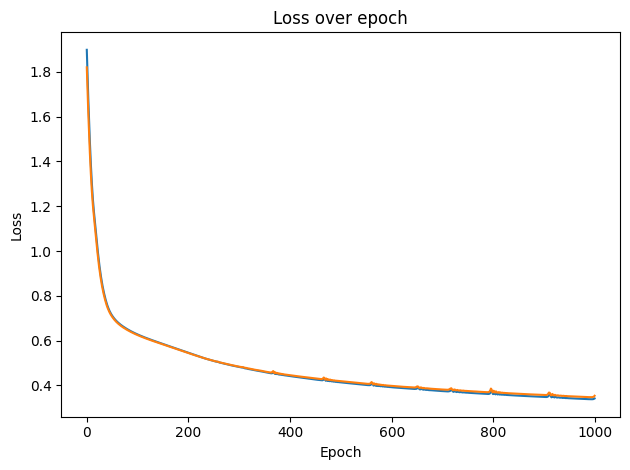

In [68]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Train Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epoch')
plt.tight_layout()
plt.show()

# =========================================

## ✅ Progress Tracker

Check off exercises as you complete them:

- ✅ Exercise 1A: Manual Gradient Verification
- ✅ Exercise 1B: Gradient Accumulation
- ✅ Exercise 2A: Convert NumPy Network
- ✅ Exercise 2B: Test Network
- ✅ Exercise 3A: Fix Buggy Training Loop
- ✅ Exercise 3B: Write Correct Training Loop
- ✅ Exercise 4A: Save/Load Model Weights
- ✅ Exercise 4B: Training Checkpoints
- ✅ Exercise 5: Boston Housing Prediction
- [ ] Challenge 1: Debug Non-Training Model
- [ ] Challenge 2: Learning Rate Finder
- ✅ Assessment Questions Q1-Q7

## 🏆 Completion Certificate

Once you complete all exercises, you've mastered:
- ✅ PyTorch tensor operations and autograd
- ✅ Building neural networks with nn.Module
- ✅ Complete training loops
- ✅ Model persistence
- ✅ Real-world applications
- ✅ Debugging skills

**You're ready for Lecture 2: Advanced PyTorch Patterns!** 🎉